In [1]:
from sklearn import tree
from nltk.corpus import stopwords
import spacy
import pandas as pd
import numpy as np
import graphviz 
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
from nltk.corpus import wordnet as wn

load data

In [2]:
hs = pd.read_csv("./TempData/model_data.csv")
print(hs.info())
mlma = pd.read_csv("./TempData/mlma_dataset.csv")
print(mlma.info())
hasoc = pd.read_csv("./TempData/hasoc2019_data.csv",delimiter="\t")
print(hasoc.info())
df = pd.concat([hs,mlma, hasoc], axis=0, ignore_index=True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3701 non-null   int64 
 1   text        3701 non-null   object
 2   label       3701 non-null   object
dtypes: int64(1), object(2)
memory usage: 86.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5647 non-null   int64 
 1   text        5647 non-null   object
 2   label       5647 non-null   object
dtypes: int64(1), object(2)
memory usage: 132.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2306 non-null   object
 1   text        2306 non-null   object
 2   labe

load models and stopwords

In [3]:
nlp = spacy.load("en_core_web_sm")
vectorizer = CountVectorizer(token_pattern = r"\b\w+\b")
words_for_exclusion = ['rt','amp','kat','-PRON-']
stop_words = set(stopwords.words('english') + words_for_exclusion) 

Corpus lemmatization

In [4]:
corpus = []
y_count = 0
Y = np.zeros((len(df['text'])))
for idx, row in df.iterrows():
    doc = nlp(row['text']) # spacy sintactic parsing
    filtered_sentence = []
    filtered_sentence = [t.lemma_ for t in doc if  not t.lemma_ in stop_words and t.pos_ not in ["PUNCT",'PROPN'] and wn.synsets(t.lemma_)] 
    corpus.append(" ".join(filtered_sentence))
    if row['label'] not in ['none','normal','NOT']:
        Y[idx] = 1
        y_count += 1

print(y_count)    
print(corpus[:10])

6295
['girl equivalent irritate asian girl couple year ago well 7', 'write', 'save pretty blonde keep tell', 'end first pm', 'bullshit know', 'cook half bird idiot', 'cook half bird idiot', 'cook half bird idiot', 'cook half bird idiot', 'stop say dumb blonde pretty face need pretty face pull']


transform corpus to word vector ()

In [5]:
X = vectorizer.fit_transform(corpus)
print(X.shape)

(11654, 6317)


Create and fit tree

In [15]:
clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=10)
clf = clf.fit(X, Y)

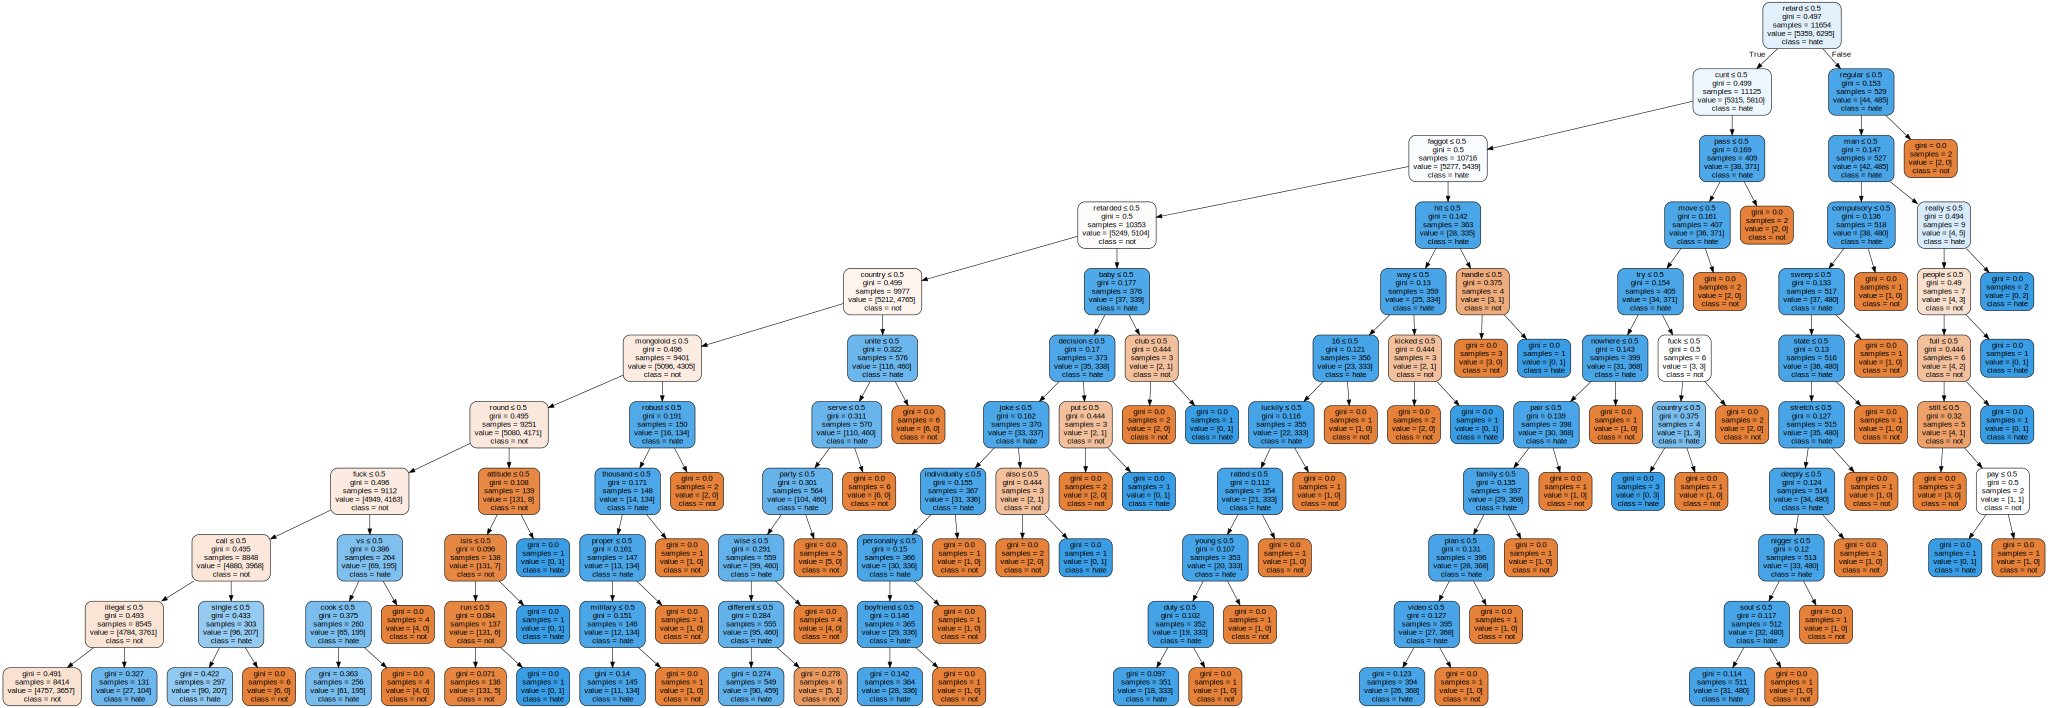

In [16]:
dot_data = tree.export_graphviz(clf, out_file=None,
    class_names=['not','hate'],
    feature_names=vectorizer.get_feature_names(),
    filled=True, rounded=True,  special_characters=True) 

graph = graphviz.Source(dot_data) 
graph.render("./twitter_data/tree") 

display(graphviz.Source(dot_data))

In [38]:
a = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [39]:
a.head()

,0,1,10,100,1000,10000,105,10th,11,110,...,yrs,yummy,z,zealot,zero,zing,zionist,zone,zoo,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
a.to_csv("./twitter_data/word_vector.csv")

## Word Frequency

In [54]:
count_list = X.toarray().sum(axis=0)
labels = vectorizer.get_feature_names()
word_frequency = pd.DataFrame( columns=["word","frequency"])
word_frequency['word'] = labels
word_frequency['frequency'] = count_list

word_frequency = word_frequency.sort_values(by=['frequency'], ascending=False)


word_frequency.to_csv("./twitter_data/word_freqency.csv")
word_frequency.head()


,word,frequency
2506,go,767
2482,get,744
3256,like,729
1336,country,571
4680,retard,533


# Interative plot

In [69]:
labels = vectorizer.get_feature_names()
def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = tree.DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf)
    estimator.fit(X, Y)
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=labels
      , class_names=['not','hate']
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return estimator

In [71]:
inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[20,30,40,50,60,70,80,100]
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…